# Data Collection and Visualization for the Drinks Storage project
This notebook collects, visualizes and stores data from two sources: Git and Grafana.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt

In [3]:
import io
import os
import requests
import time
import tempfile

import matplotlib.dates as dates
from pydriller import RepositoryMining  # pip install pydriller
import git                              # pip install gitpython
import yaml                             # pip install pyyaml

## Git

The git repository [`drinks-storage-mqtt`](https://github.com/flipdot/drinks-storage-mqtt) stores relevant information about the individual scales' configuration (cf. [`config.yaml`](https://github.com/flipdot/drinks-storage-mqtt/blob/master/config.yaml)).
Of special importance are:

* Commits' dates
* Specific configuration at these dates
    * `tare_raw`
        * Tare value in raw sensor values
    * `crate_raw`
        * Single crate weight in raw sensor values
    * `kilogram_raw`
        * Single kilogram in raw sensor values
    * `tolerance_kg`
        * Tolerance of a measurement to still map to the nearest crate count
        * Rejected if measurement is beyond this value

### Collect

In [4]:
# Set paths for drinks-storage-mqtt repository
TMP_DIR = tempfile.TemporaryDirectory(prefix='drinks-storage-dataviz-')
DS_MQTT_REPO = os.path.join(TMP_DIR.name, 'drinks-storage-mqtt')
DS_MQTT_URL = 'https://github.com/flipdot/drinks-storage-mqtt.git'
DS_MQTT_CFG = 'config.yaml'
PLT_FIGSIZE = (14, 4)
PLT_DPI = 250
PLT_ALPHA_MAX = .3
PLT_ALPHA_SCALE = .3
DSV_DIR = 'data'
DSV_DELIMITER = ';'
DSV_GIT = f'{DSV_DIR}/drinks-storage-git.dsv'
DSV_GRAFANA_RAW = f'{DSV_DIR}/drinks-storage-grafana-raw.dsv'
DSV_GRAFANA_CRATES = f'{DSV_DIR}/drinks-storage-grafana-crates.dsv'

In [5]:
# Clone repository, if files are not yet present locally
if not os.path.isdir(DS_MQTT_REPO):
    git.Git(TMP_DIR.name).clone(DS_MQTT_URL)

In [6]:
# Create list of commit hashes that contain changes in the config file and their respective timestamps
commit_hist_full = []
for commit in RepositoryMining(DS_MQTT_REPO, filepath=DS_MQTT_CFG).traverse_commits():
    for modification in commit.modifications:
        if modification.filename == DS_MQTT_CFG:
            commit_hist_full.append({'hash': commit.hash, 'ts_start': commit.committer_date})

In [7]:
# Use time windows for each commit for easier application later on
for i, commit in enumerate(commit_hist_full):
    if i == 0:
        continue
    commit_hist_full[i - 1]['ts_end'] = commit['ts_start']

In [8]:
# Add scales' configuration at given point in time by interpreting file for given hashes
repo = git.Repo(DS_MQTT_REPO)
for i, commit in enumerate(commit_hist_full):
    commit_obj = repo.commit(commit['hash'])
    commit_file = commit_obj.tree / DS_MQTT_CFG
    with io.BytesIO(commit_file.data_stream.read()) as f:
        commit_cfg_str = f.read().decode('utf-8')
    commit_cfg_full = yaml.safe_load(commit_cfg_str)
    try:
        commit_cfg = commit_cfg_full['scales']
    except:
        continue
    # Skip configs that don't contain all scales yet
    if len(commit_cfg) > 3:
        commit_hist_full[i]['config'] = commit_cfg

In [9]:
# Remove commits that don't contain all scales yet
commit_hist_idx = []
for i, commit in enumerate(commit_hist_full):
    if 'config' in commit.keys():
        commit_hist_idx.append(i)
commit_hist = [commit_hist_full[i] for i in commit_hist_idx]

In [10]:
# Reorder data structure grouped by drink name for easier plotting
scales_hist = {}
for commit in commit_hist:
    cfg = commit['config']
    for v in cfg.values():
        # Create empty lists to append to if key not present
        scale_name = v['scale_name']
        # Skip configs for old drinks not served anymore
        if scale_name == 'fritz_cola':
            continue
        if not scale_name in scales_hist.keys():
            scales_hist[scale_name] = []
            
        # Circumvent typos and old style using 'crate_weight' in kg instead of raw sensor values
        try:
            # FIXME mio_guarana seems to not work yet
            scales_hist[scale_name].append({
                'ts_start': commit['ts_start'],
                'ts_end': commit['ts_end'],
                'tare_raw': v['tare_raw'],
                'crate_raw': v['crate_raw'],
                'kilogram_raw': v['kilogram_raw'],
                'tolerance_kg': v['tolerance_kg'],
            })
        except:
            continue

### Visualize

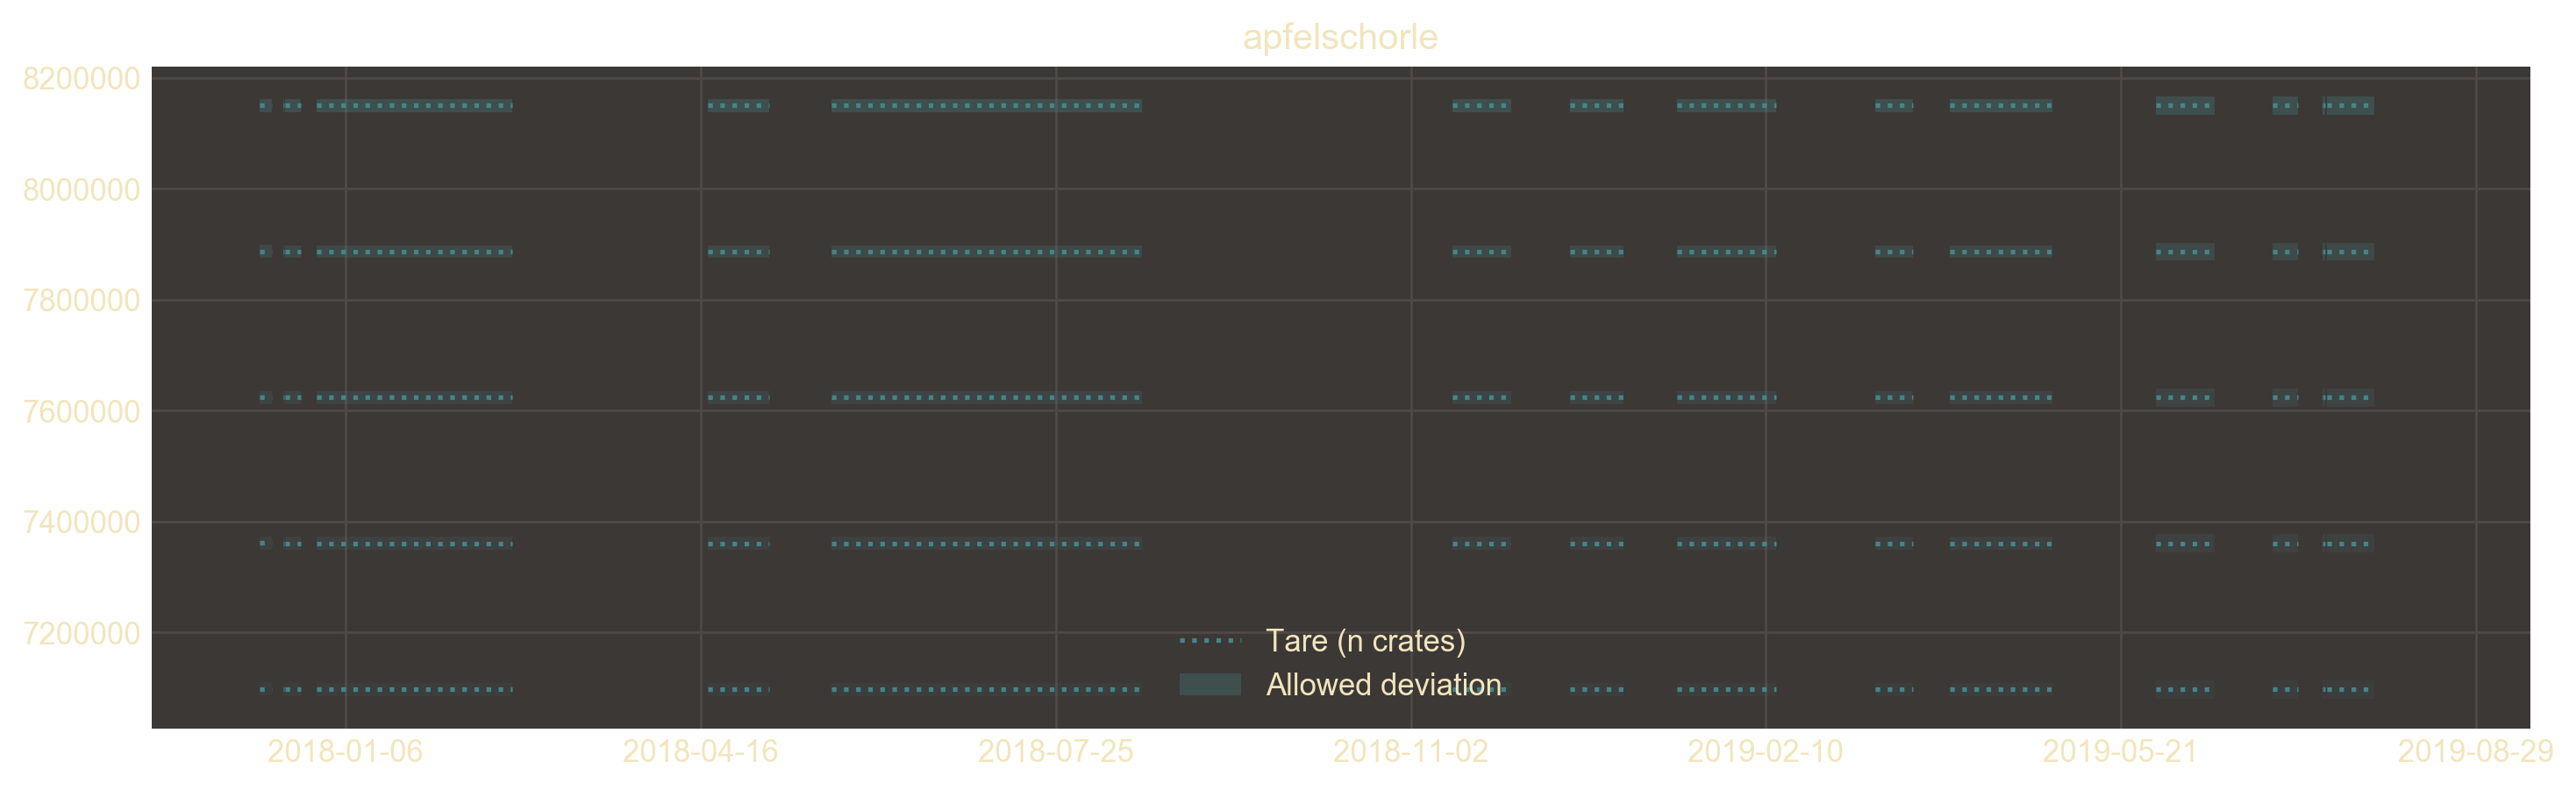

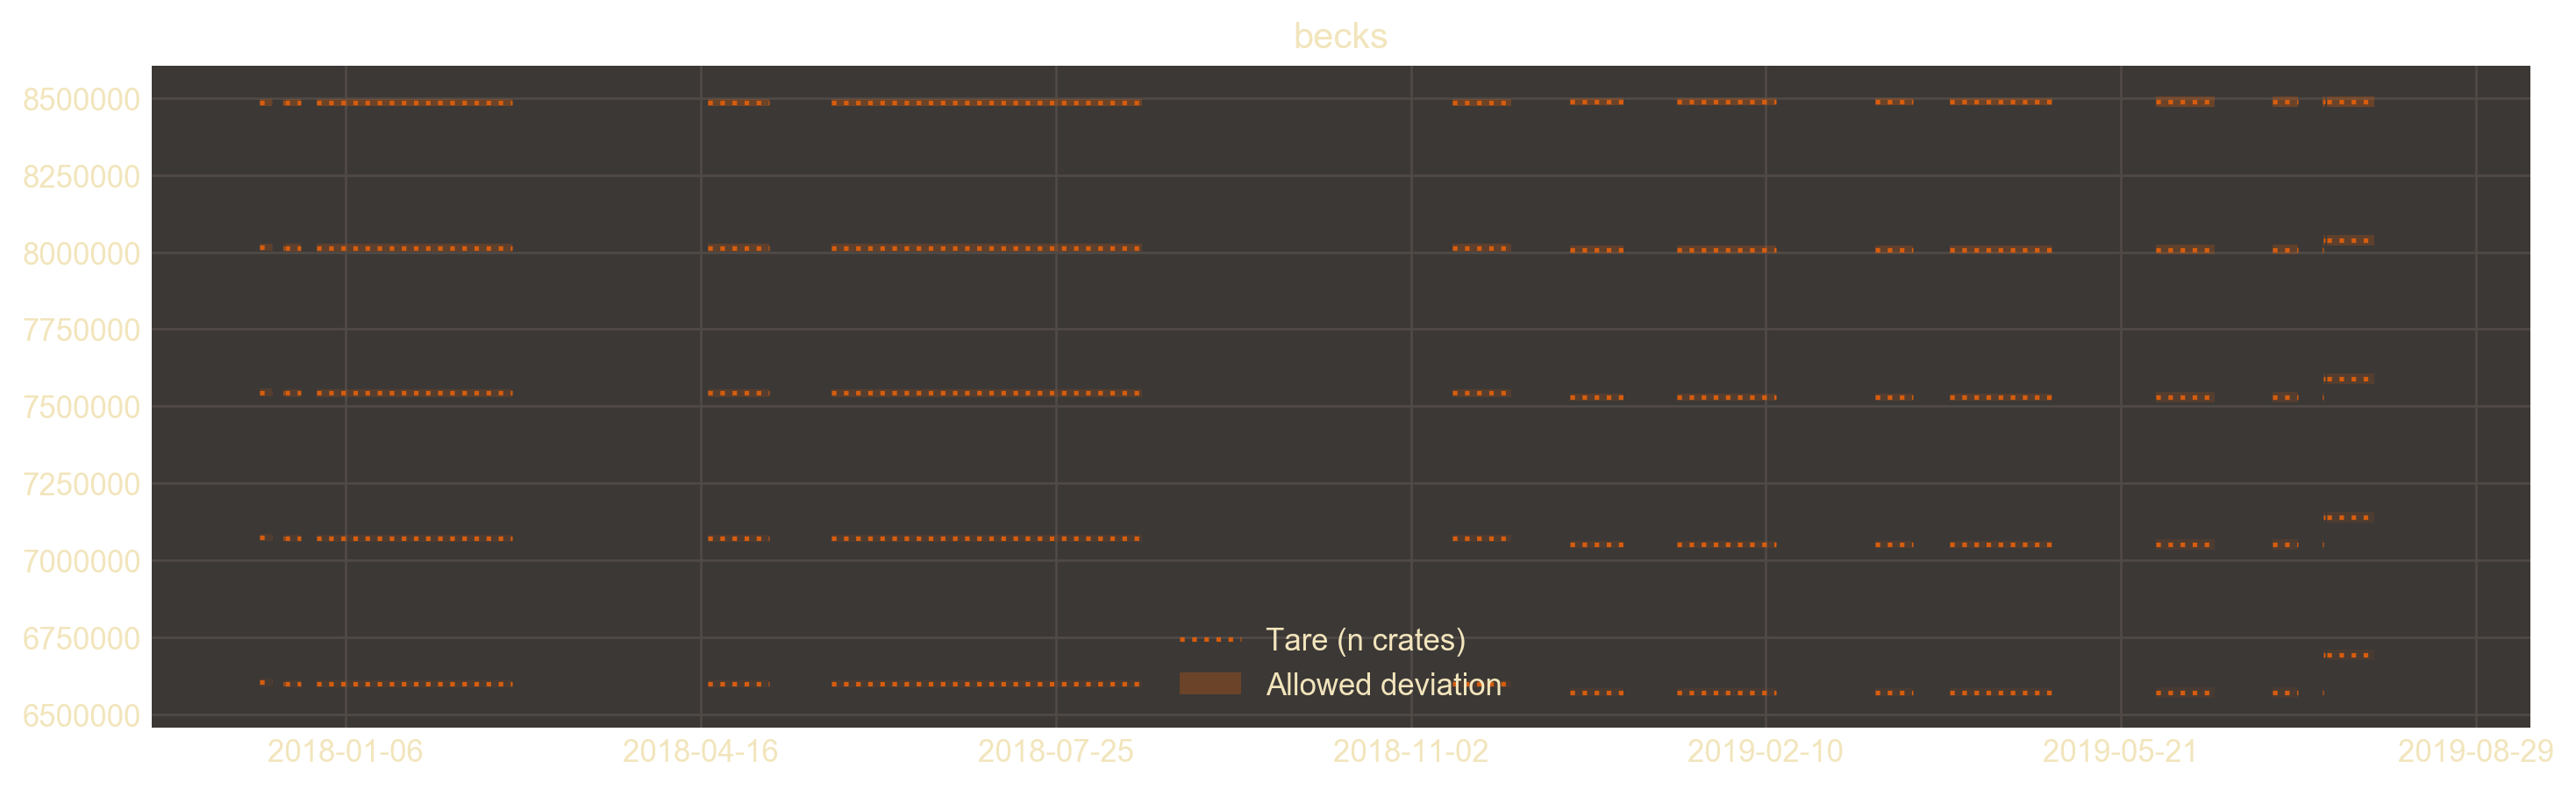

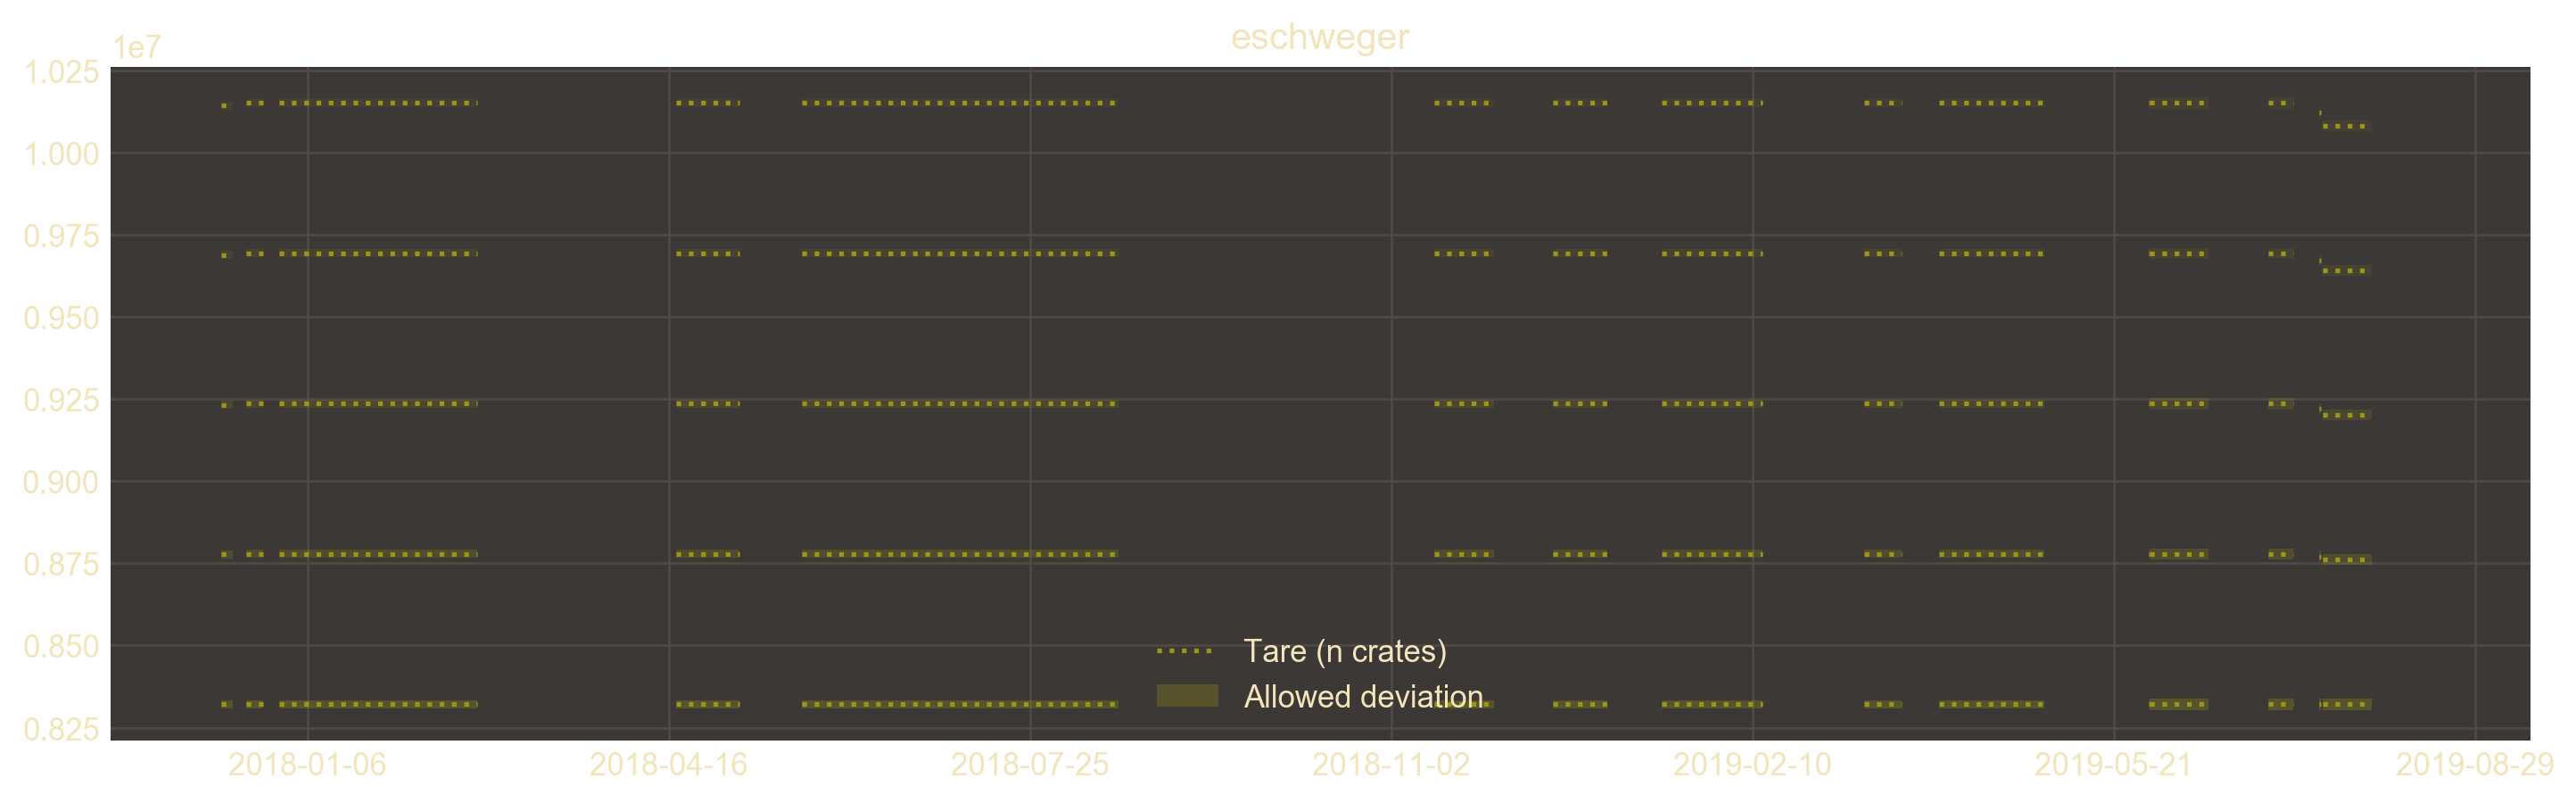

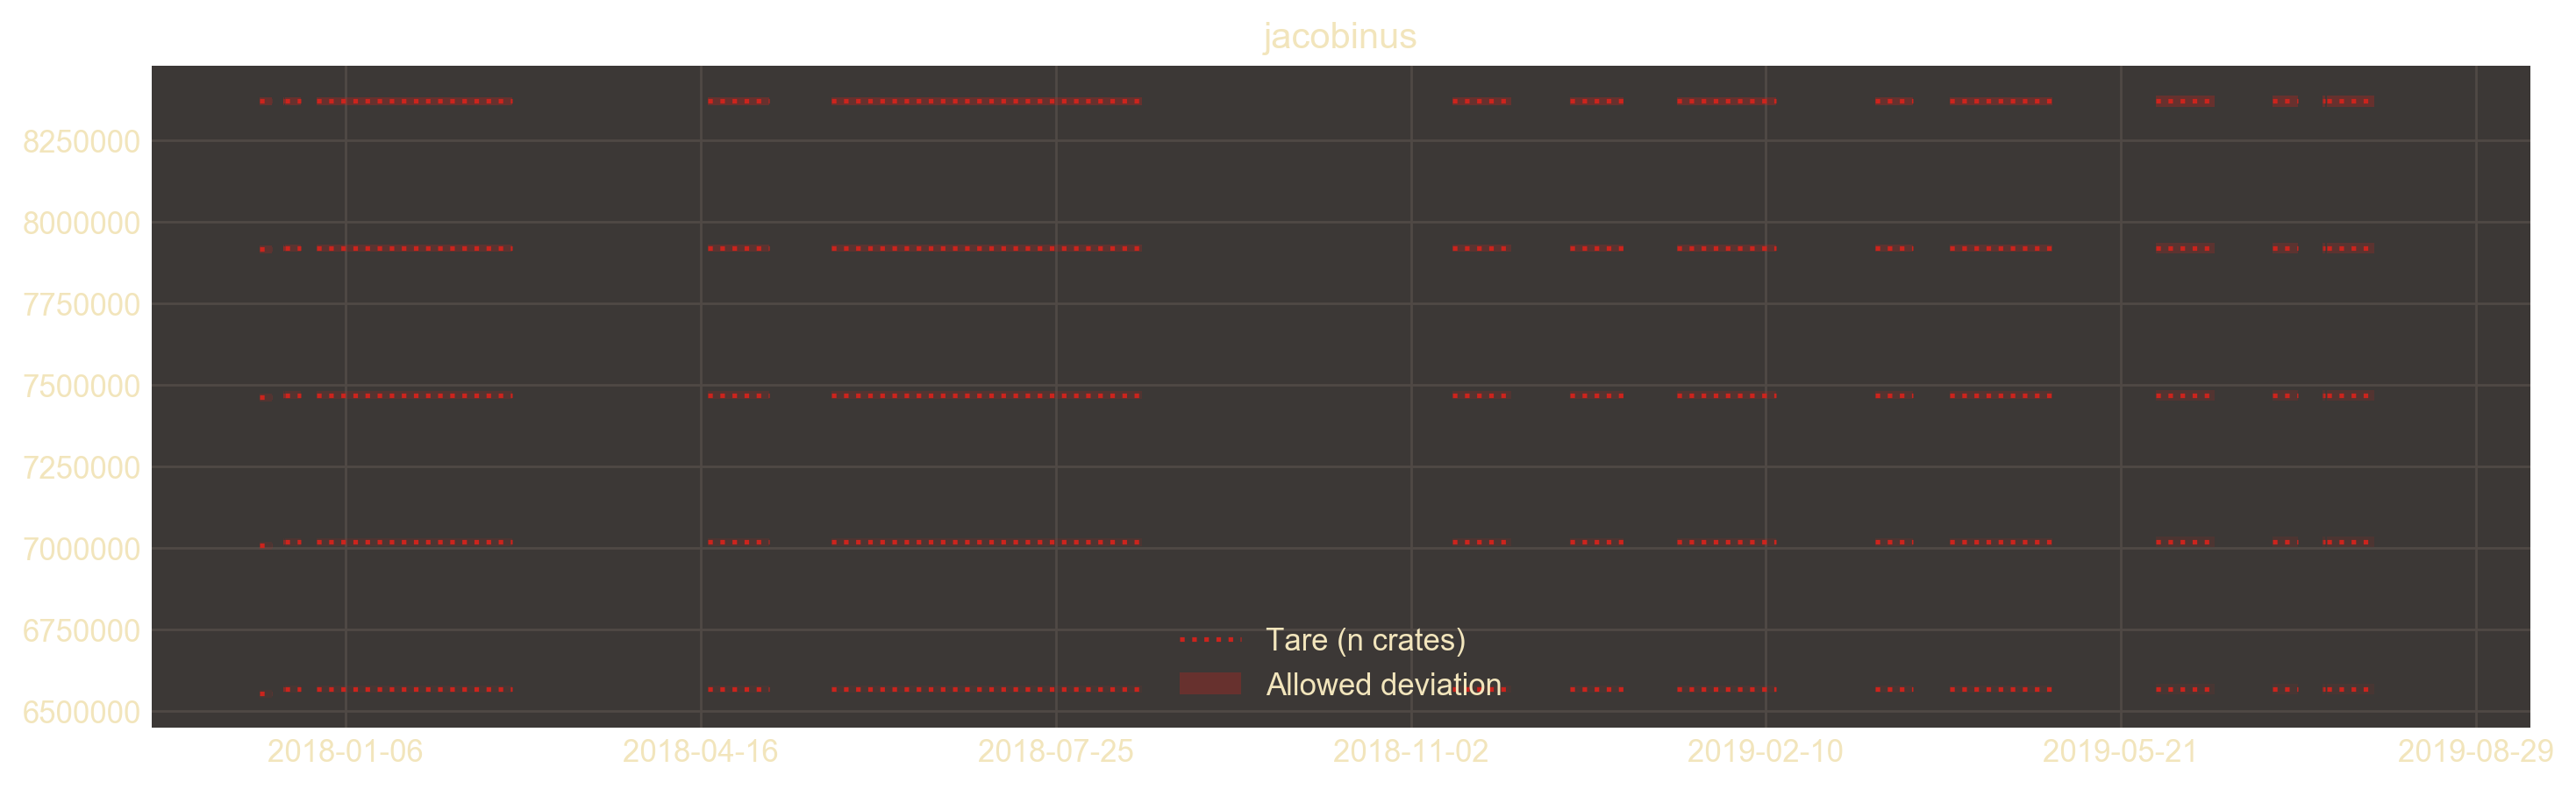

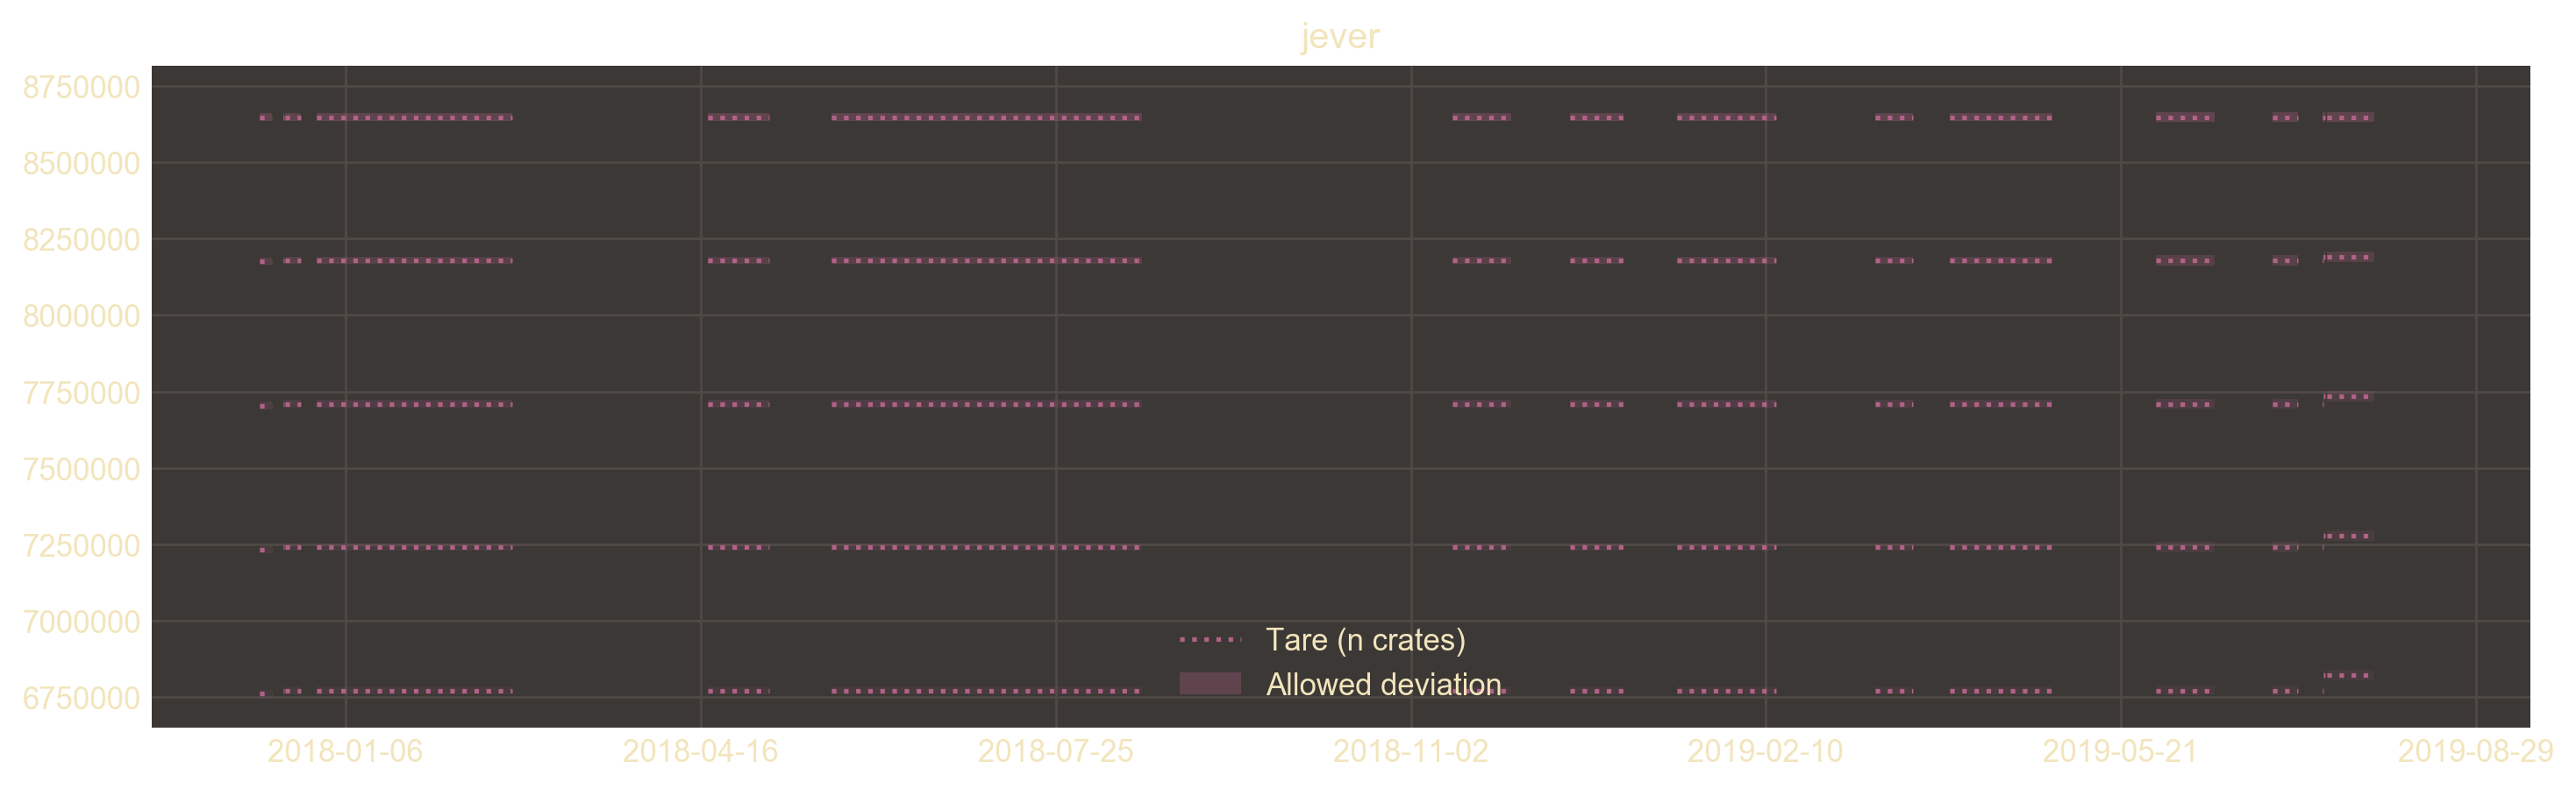

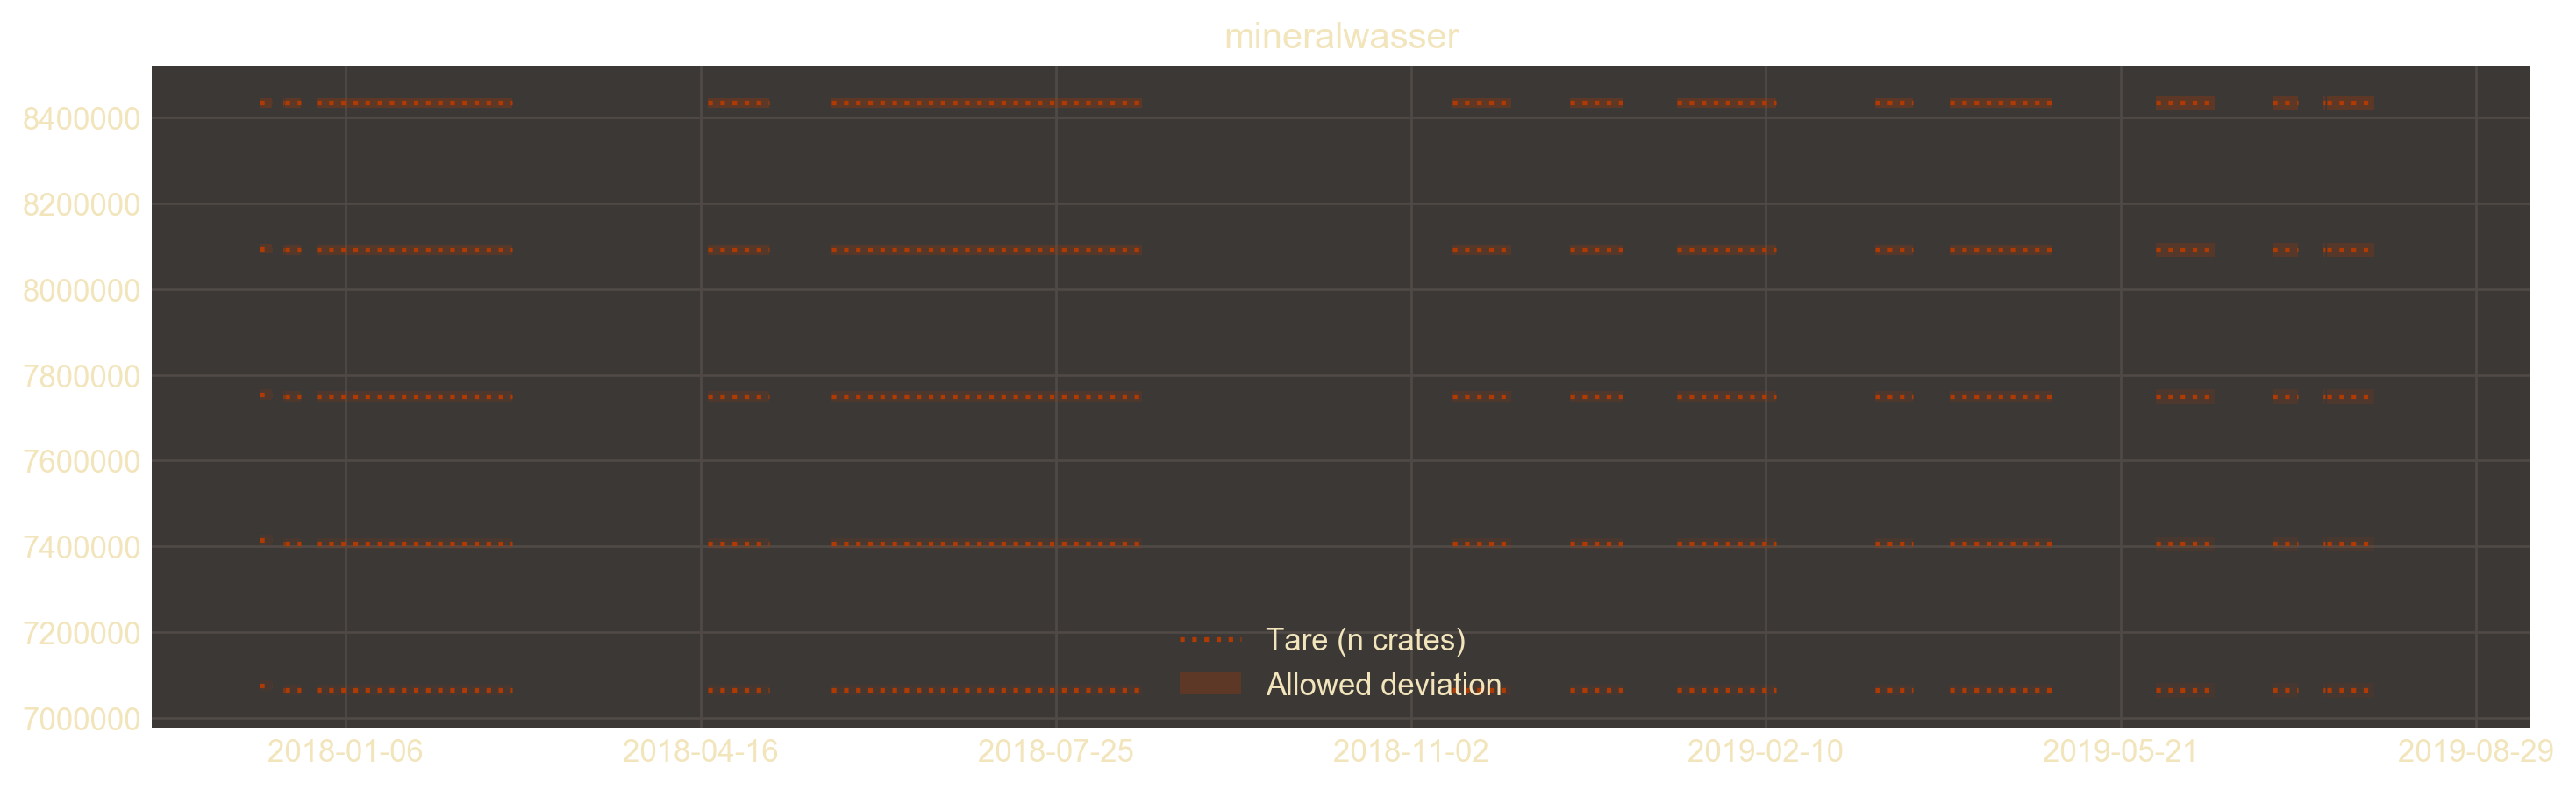

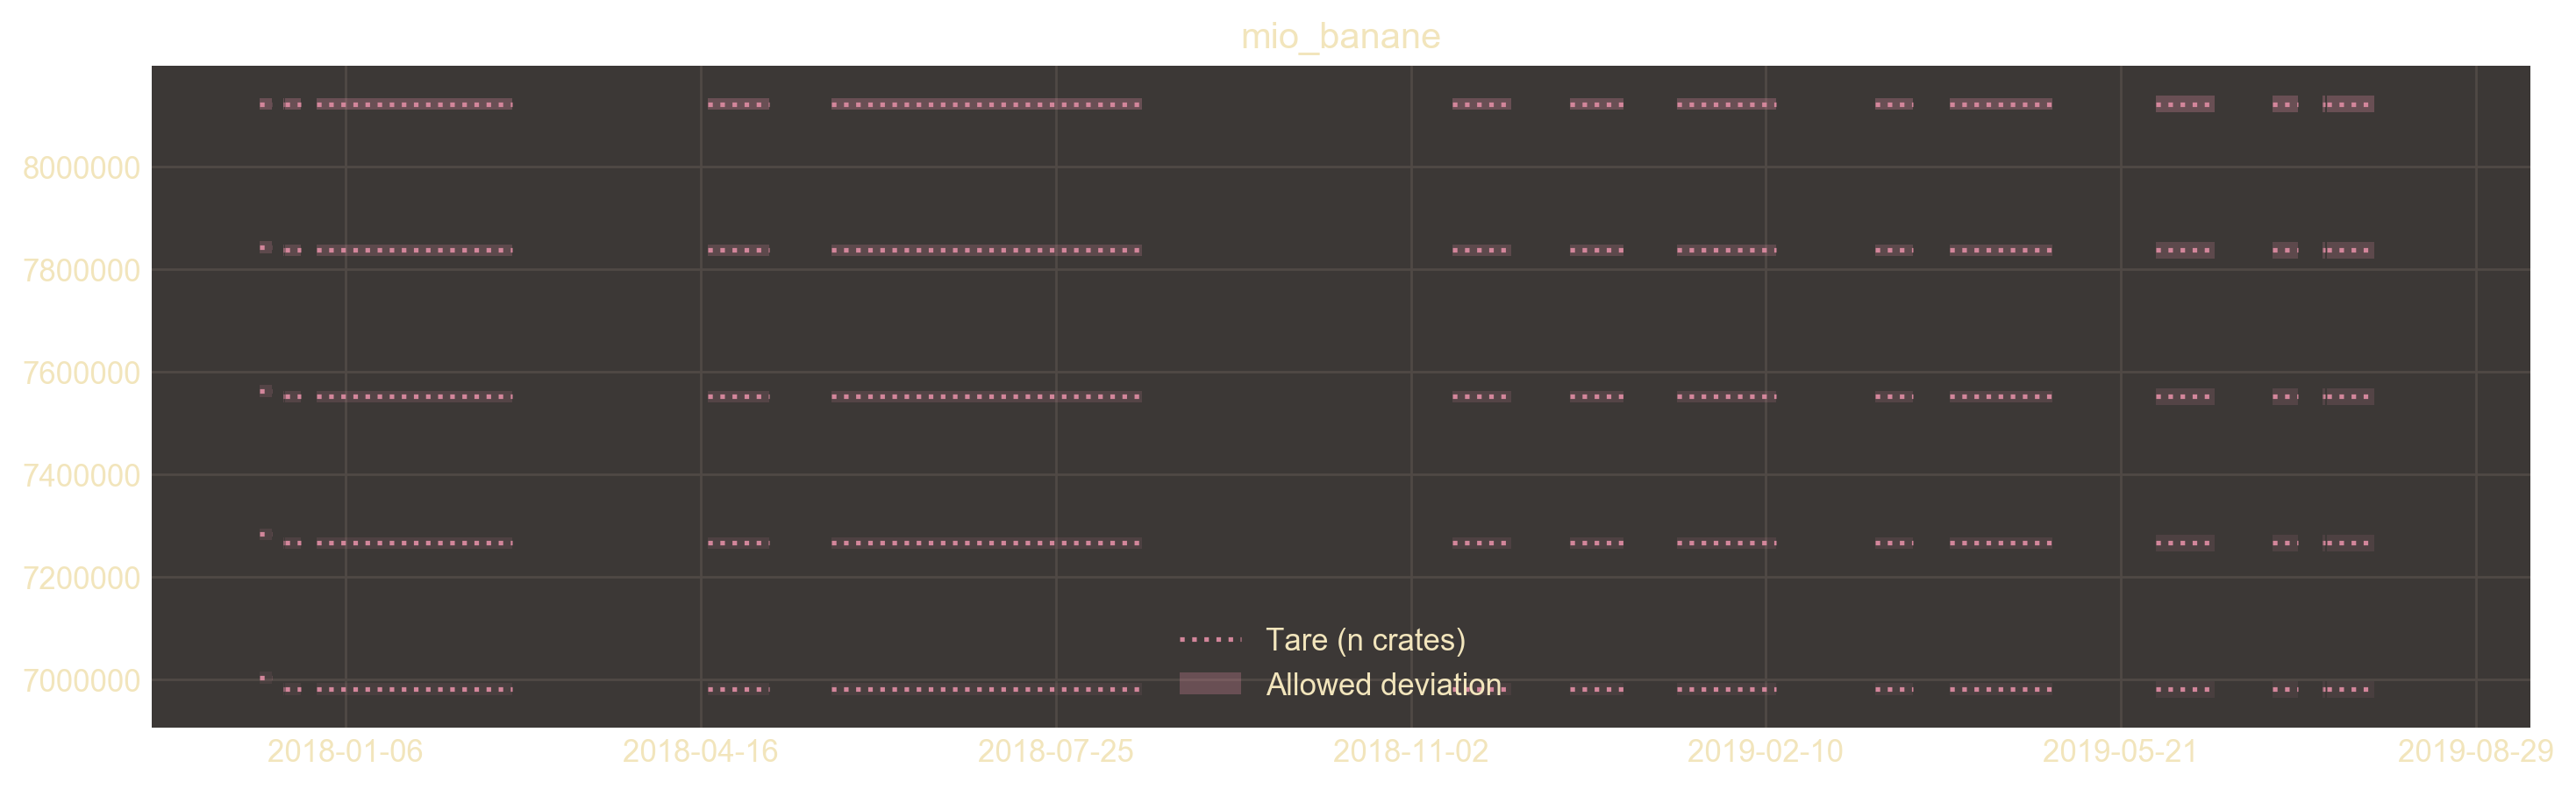

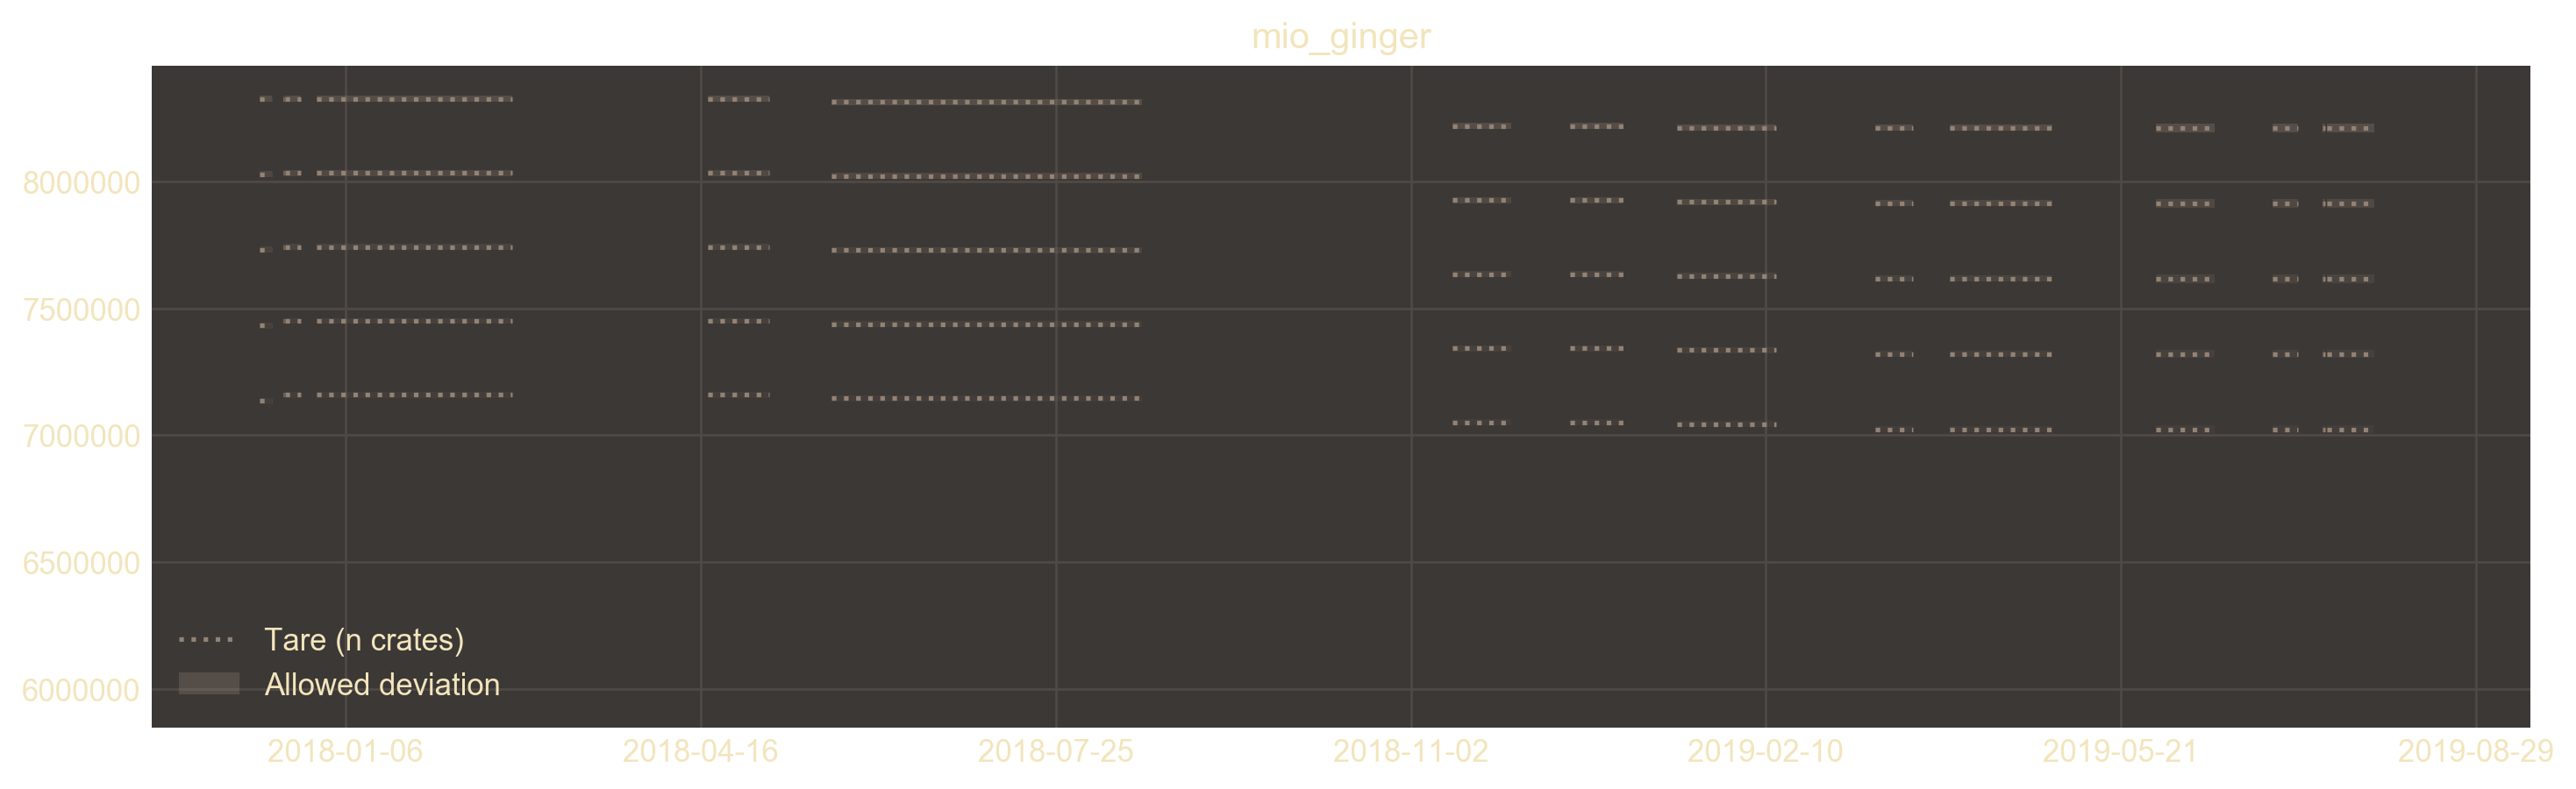

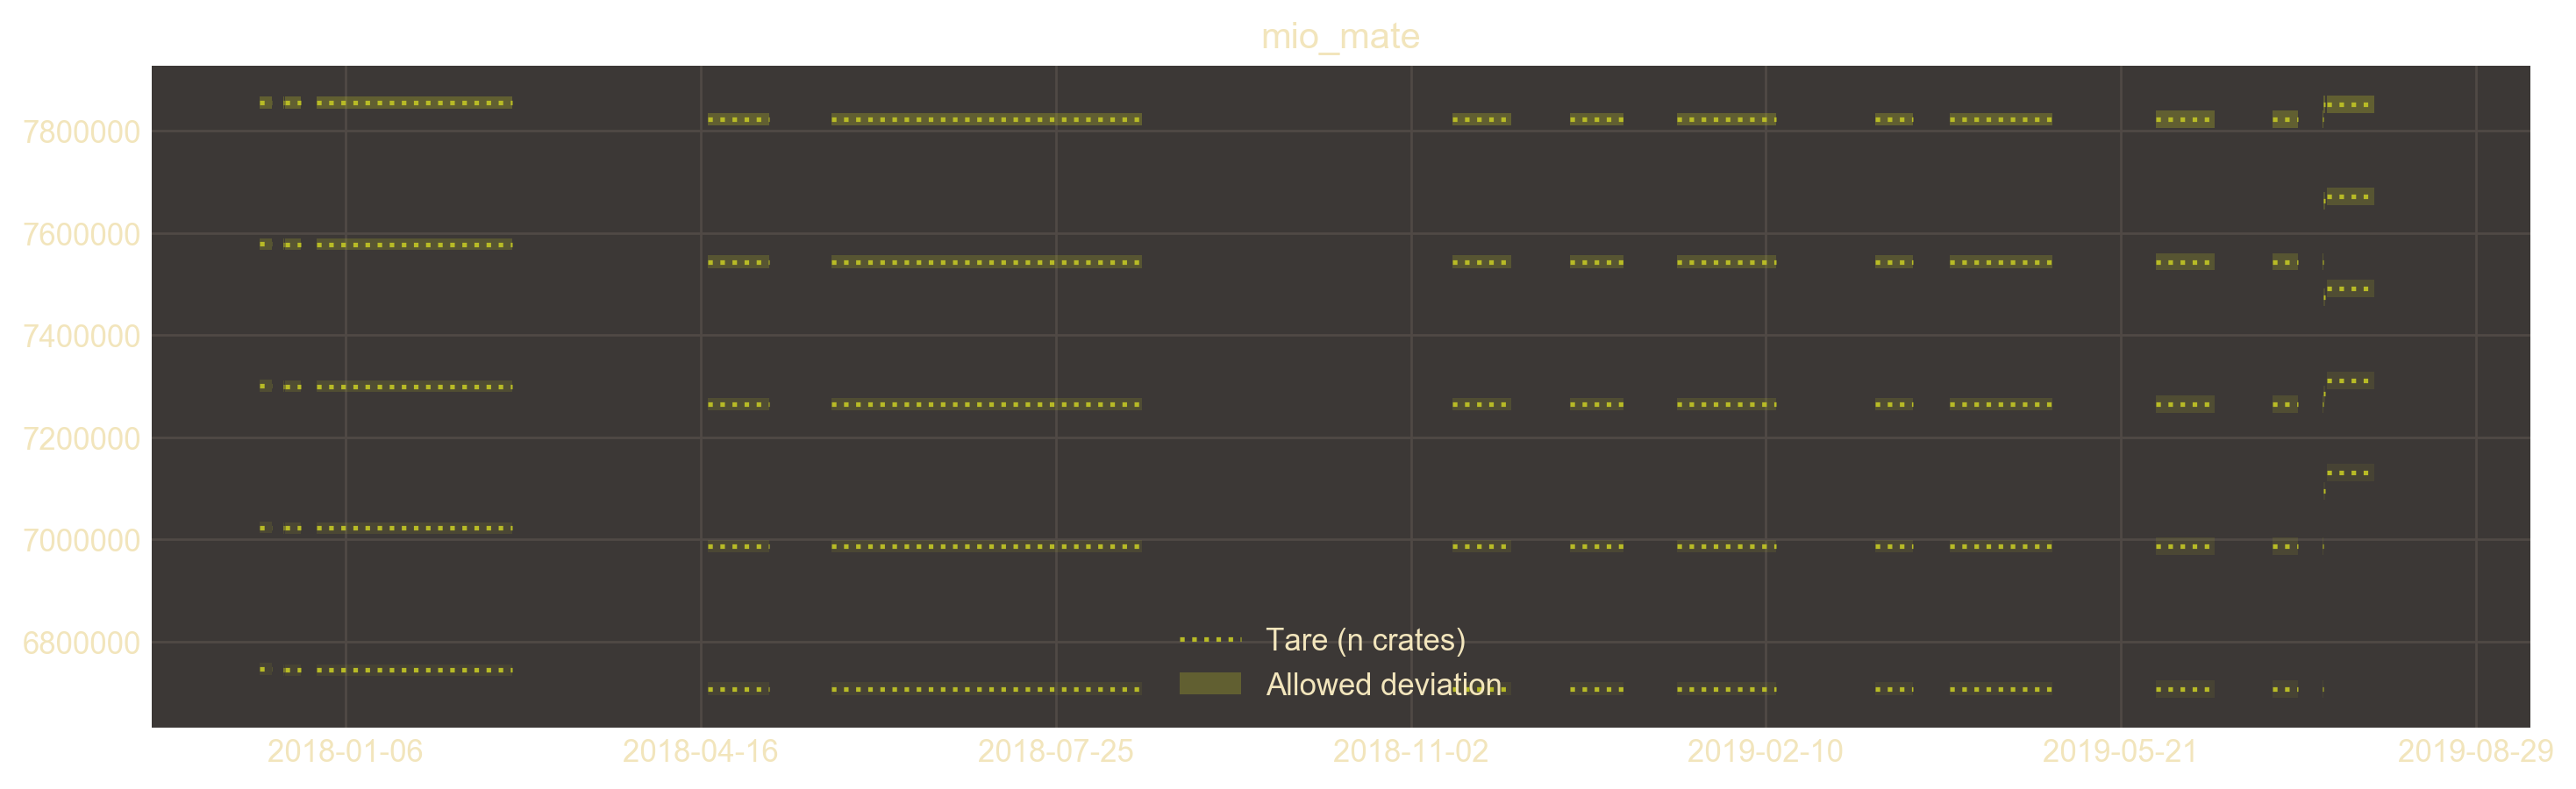

In [ ]:
# Plot all drinks' relevant metrics
PLT_DATE_FMT = dates.DateFormatter('%Y-%m-%d')
for i, (scale_name, scale_vals) in enumerate(scales_hist.items()):
    # FIXME grapefruit_sprudel has too high extrema somewhere
    # FIXME mio_guarana has no data yet
    if scale_name == 'grapefruit_sprudel' or scale_name == 'mio_guarana':
        continue
    fig, ax = plt.subplots(figsize=PLT_FIGSIZE, dpi=PLT_DPI)
    label_tare = 'Tare (n crates)'
    label_deviation = 'Allowed deviation'
    for v in scale_vals:
        ts_start = dates.date2num(v['ts_start'])
        ts_end = dates.date2num(v['ts_end'])

        x = np.arange(ts_start, ts_end, (ts_end - ts_start) / 2)

        # Highlight areas for crates and their limits
        # i = drink id
        # j = crate count
        c = f'C{i}'
        for j in range(0, 5):
            y = x * 0 + v['tare_raw'] + j * v['crate_raw']
            theta = v['tolerance_kg'] * v['kilogram_raw']

            plt.title(scale_name)
            ax.plot(x, y, ':', c=c, label=label_tare)
            ax.fill_between(
                x,
                y - theta, y + theta,
                alpha=PLT_ALPHA_MAX * np.exp(-j * PLT_ALPHA_SCALE),
                facecolor=c,
                label=label_deviation,
            )
            label_tare = None
            label_deviation = None
        
        # TODO Combine this plot with Grafana's data

    ax.xaxis.set_major_formatter(PLT_DATE_FMT)
    plt.legend()
    plt.show()

### Storing
Removing the need of cloning a repository for each visualization, the data is stored in a DSV file within this repository (cf. `data/drinks-storage-git.csv`).

In [ ]:
# Create DSV data directory if not already present
if not os.path.isdir(DSV_DIR):
    os.mkdir(DSV_DIR)

# Only save DSV file if not already present
if not os.path.isfile(DSV_GIT):
    dsv_string = ''
    d = DSV_DELIMITER
    dsv_header = f'name{d}ts_start{d}ts_end{d}tare_raw{d}crate_raw{d}kilogram_raw{d}tolerance_kg\n'
    dsv_string += dsv_header
    for i, (scale_name, scale_vals) in enumerate(scales_hist.items()):
        for v in scale_vals:
            ts_start = int(v['ts_start'].timestamp())
            ts_end = int(v['ts_end'].timestamp())
            tare_raw = v['tare_raw']
            crate_raw = v['crate_raw']
            kilogram_raw = v['kilogram_raw']
            tolerance_kg = v['tolerance_kg']
            dsv_line = f'{scale_name}{d}{ts_start}{d}{ts_end}{d}{tare_raw}{d}{crate_raw}{d}{kilogram_raw}{d}{tolerance_kg}\n'
            dsv_string += dsv_line
    with open(DSV_GIT, 'w') as fh:
        fh.write(dsv_string)

## Grafana
flipdot's [Grafana instance](https://stats.flipdot.org/) stores data made available through its [API](http://api.flipdot.org/) (cf. [spaceAPI](http://spaceapi.net/)).
This record allows for historic analysis of the data and may yield insights on the individual scales fault.

### Collection

In [ ]:
STATS_TS_FIRST_RAW_DATA = 1562097540
STATS_HOST = 'stats.flipdot.org'
STATS_ORG_ID = 1
STATS_API_URL = f'https://{STATS_HOST}/api/datasources/proxy/1/render'
STATS_QUERIES = {
    'raw': {
        'headers': {
            'X-Dashboard-Id': '23',
            'X-Panel-Id': '35',
            'X-Grafana-Org-Id': '1',
        },
        'query': {
            'target': [
                'alias(scale(fd.space.drinks_raw.cellar.esp_3983498.raw, -1), \'mio_cola\')',
                'alias(scale(fd.space.drinks_raw.cellar.esp_3975289.raw, -1), \'mio_mate\')',
                'alias(fd.space.drinks_raw.cellar.esp_3975866.raw, \'mio_ginger\')',
                'alias(scale(fd.space.drinks_raw.cellar.esp_4822813.raw, -1), \'apfelschorle\')',
                'alias(scale(fd.space.drinks_raw.cellar.esp_2370727.raw, -1), \'jever_fun\')',
                'alias(scale(fd.space.drinks_raw.cellar.esp_3983459.raw, -1), \'mineralwasser\')',
                'alias(scale(fd.space.drinks_raw.cellar.esp_4823672.raw, -1), \'grapefruit_sprudel\')',
            ],
            'format': 'json',
        }
    },
    'crates': {
        'headers': {
            'X-Dashboard-Id': '23',
            'X-Panel-Id': '29',
            'X-Grafana-Org-Id': '1',
        },
        'query': {
            'target': [
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.becks.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.eschweger.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.jacobinus.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.jever.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.radler.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.koestritzer.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.mio_guarana.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.mio_cola.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.mio_mate.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.mio_ginger.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.apfelschorle.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.jever_fun.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.mineralwasser.crt, \'3h\', \'max\'), -1), 4)',
                'aliasByNode(transformNull(smartSummarize(fd.space.drinks.cellar.grapefruit_sprudel.crt, \'3h\', \'max\'), -1), 4)',
                'alias(smartSummarize(sumSeries(transformNull(fd.space.drinks.cellar.*.crt, -1)), \'3h\', \'max\'), \'Total\')',
            ],
            'format': 'json',
        }
    }
}

In [ ]:
def get_stats(name, ts_start, ts_end, max_data_points=2000):
    headers = STATS_QUERIES[name]['headers']
    query = STATS_QUERIES[name]['query']
    query['from'] = str(ts_start)
    query['until'] = str(ts_end)
    query['maxDataPoints'] = str(max_data_points)
    r = requests.post(STATS_API_URL, headers=headers, data=query)
    if r.status_code != 200:
        return False
    return r.json()

In [ ]:
def plot_stats(stats_data):
    for i, scale in enumerate(stats_data):
        c = f'C{i}'
        name = scale['target']
        data = np.array(scale['datapoints'])
        x = dates.epoch2num(data[:, 1])
        y = data[:, 0]

        fig, ax = plt.subplots(figsize=PLT_FIGSIZE, dpi=PLT_DPI)
        plt.plot(x, y, c=c)
        plt.title(name)
        ax.xaxis.set_major_formatter(PLT_DATE_FMT)
        plt.show()

In [ ]:
# Get and plot raw data using Grafana's API
data_stats_raw = get_stats('raw', ts_start=STATS_TS_FIRST_RAW_DATA, ts_end='now')
plot_stats(data_stats_raw)

In [ ]:
# Get and plot crate data using Grafana's API
data_stats_crates = get_stats('crates', ts_start=STATS_TS_FIRST_RAW_DATA, ts_end='now')
plot_stats(data_stats_crates)

### Storing
Removing the need of querying the Grafana API for each visualization, the data is stored in two DSV files within this repository (cf. `data/drinks-storage-grafana-{raw,crates}.dsv`).

In [ ]:
def save_grafana_data(file, data):
    if not os.path.isfile(file):
        d = DSV_DELIMITER
        dsv_string = f'name;ts;value\n'
        for scale in data:
            name = scale['target']
            data = np.array(scale['datapoints'])
            for sample in data:
                time = sample[1]
                value = sample[0]
                dsv_string += f'{name}{d}{time}{d}{value}\n'
        with open(file, 'w') as fh:
            fh.write(dsv_string)

In [ ]:
# Only save DSV file if not already present
save_grafana_data(DSV_GRAFANA_RAW, data_stats_raw)
save_grafana_data(DSV_GRAFANA_CRATES, data_stats_crates)